Carga de librerías

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from yaml import safe_load

Definición de rutas relativas del archivo

In [2]:
ROOT = os.path.dirname(os.getcwd())
DATA = os.path.join(ROOT, 'data')

Carga de archivo de configuración

In [3]:
with open(file=os.path.join(ROOT, 'config.yml'), mode='r') as file:
    CONFIG = safe_load(file)
file.close()

La siguiente sección está basada en el capítulo 3 de- _Data Analysis using Regression and Hierarquical Models_ de Andrew Gelman y Jennifer Hill. La secuencia de los ejercicios en el _notebook_ va en el orden de aparición de los ejemplos en el libro.

# 1. Resultados de un examen para niños

Para predictores binarios, los coeficientes de regresión lienal represetan la diferencia entre los promedios de dos grupos. Considera el ejemplo en el que se modela los resultados de una prueba de niños, y se proporciona como variable indicadora si sus madres tienen estudios de secundaria ($mother_{hs}$), el modelo que describe los resultados quedaría dado por la expresión:

$$score = 78 + 12 mother_{hs}$$

Este modelo resumen la diferencia entre el resultado promedio de los niños cuya madre no tuvo estudios de secundaria, contra el resultado promedio de aquellos niños cuya madre sí tuvo estudios.

Para ilustrarlo, primero se describen brevemente los datos:

In [4]:
# Ruta a archivo de datos
file_name = os.path.join(DATA, 'kid_iq.csv')

# Carga de datos en un dataframe
kid_iq = pd.read_csv(file_name)

# Eliminar columnas sin nombre
kid_iq.drop(
    columns=[col for col in kid_iq.columns if col.startswith('Unnamed')]
    ,inplace=True)

# Descripción básica de los datos
kid_iq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   kid_score  434 non-null    int64  
 1   mom_hs     434 non-null    int64  
 2   mom_iq     434 non-null    float64
 3   mom_work   434 non-null    int64  
 4   mom_age    434 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 17.1 KB


Ahora se define una función para el modelo de regresión lineal y se generan datos:

In [7]:
# Modelo de regresión lineal
def kid_score(mother_hs): return 78 + 12 * mother_hs

# Datos simulados con el modelo
x = np.linspace(start=0, stop=1, num=100)
y = kid_score(x)

Se puede visualizar el comporamiento del resultado de la prueba condicionado a si la madre concluyó estudios de secundaria, junto con el modelo que describe su comportamiento

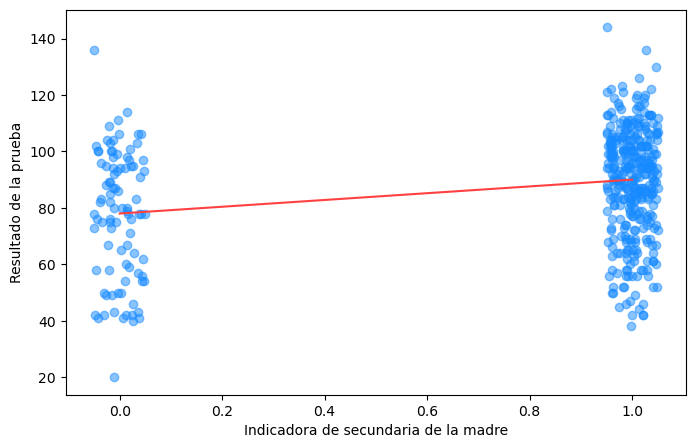

In [11]:
# Configuraciones de figura
fig, ax = plt.subplots(figsize = (8,5))

# Elementos de visualización
ax.scatter(
    x=kid_iq.mom_hs + np.random.uniform(low=-0.05, high=0.05, size=kid_iq.shape[0])
    ,y=kid_iq.kid_score
    ,color=CONFIG['graficas']['colors']['azul']
    ,alpha=0.5)

ax.plot(
    x, y
    ,color=CONFIG['graficas']['colors']['rojo'])

# Anotaciones y estilo
ax.set_xlabel('Indicadora de secundaria de la madre')
ax.set_ylabel('Resultado de la prueba')


plt.show()